In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from google.colab import drive 
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import nltk
import matplotlib.pyplot as plt
SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords
import string
from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
stopWords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_FOLDER = '/content/drive/My Drive/kaggle_nlp/data/'
train = pd.read_csv(DRIVE_FOLDER + 'train.csv')
test = pd.read_csv(DRIVE_FOLDER + 'test.csv')
test_labels = pd.read_csv(DRIVE_FOLDER + 'test_labels.csv')
test = pd.merge(test, test_labels, on='id' )
test = test[(test.toxic != -1) | (test.severe_toxic != -1) | (test.obscene != -1) | (test.threat != -1) | (test.insult != -1) | (test.identity_hate != -1)]


In [ ]:
#Convert text to lower case
train['comment_text'] = train['comment_text'].str.lower()


test['comment_text'] = test['comment_text'].str.lower()

In [ ]:
#Clean up text
import re
from nltk.stem.snowball import SnowballStemmer
def clean(s):

  
  # remove punctuations
  
  s= re.sub(r'[^\w\s]+', '', s)
 
  #replace numbers

  s = re.sub(r'[0-9]+','', s)
  s = re.sub(r'\.+','', s)
 
  #remove special characters
  s = re.sub(r'!@#$%^&*?', '', s)
 
 
  return s
train['comment_text'] = train['comment_text'].map(lambda x: clean(x))
test['comment_text'] = test['comment_text'].map(lambda x: clean(x))

print(train.loc[12,'comment_text'])

hey what is it
  talk 
what is it an exclusive group of some wp talibanswho are good at destroying selfappointed purist who gang up any one who asks them questions abt their antisocial and destructive noncontribution at wp

ask sityush to clean up his behavior than issue me nonsensical warnings


In [ ]:
#remove stop words
def stop_words(s):
  w = [i for i in s.split(' ') if i not in stopWords]
  return ' '.join(w)

train['comment_text'] = train['comment_text'].map(lambda x: stop_words(x))
print(train.loc[12,'comment_text'])

hey it
  talk 
what exclusive group wp talibanswho good destroying selfappointed purist gang one asks questions abt antisocial destructive noncontribution wp

ask sityush clean behavior issue nonsensical warnings


In [ ]:
#stem words
stemmer = SnowballStemmer('english')
def stem_words(s):
  w = [stemmer.stem(i) for i in s.split(' ')]

  return ' '.join(w)

train['comment_text'] = train['comment_text'].map(lambda x: stem_words(x))
print(train.loc[12,'comment_text'])

hey it
  talk 
what exclus group wp talibanswho good destroy selfappoint purist gang one ask question abt antisoci destruct noncontribut wp

ask sityush clean behavior issu nonsens warn


In [ ]:
#lemmatize words

lm = WordNetLemmatizer()
def lemmatize_words(s):
  w = [lm.lemmatize(i) for i in s.split(' ')]

  return ' '.join(w)

train['comment_text'] = train['comment_text'].map(lambda x: lemmatize_words(x))
print(train.loc[12,'comment_text'])

hey it
  talk 
what exclus group wp talibanswho good destroy selfappoint purist gang one ask question abt antisoci destruct noncontribut wp

ask sityush clean behavior issu nonsens warn


In [ ]:
#feature development
x_train = train['comment_text']
y_train = train.iloc[:,2:]
x_test = test['comment_text']
y_test = test.iloc[:,2:]
word_limit = 400
len = 100
m_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=word_limit, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
m_tokenizer.fit_on_texts(x_train)
t_train = m_tokenizer.texts_to_sequences(x_train)
t_test = m_tokenizer.texts_to_sequences(x_test)
train_x = pad_sequences(t_train, maxlen=len)
test_x = pad_sequences(t_test, maxlen=len)


In [ ]:
import keras
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import Sequential
embed_layer = 50
embedding_layer = Embedding(word_limit,embed_layer)

inp=Input(shape=(len, ))
embedded_sequences = embedding_layer(inp)
x = LSTM(64, return_sequences = True) (embedded_sequences)

x = LSTM(64, return_sequences = True) (x)

x = GlobalMaxPool1D()(x)
x= Dropout(0.2)(x)
x= Dense(6,activation='sigmoid') (x)
model = Model(inputs=inp, outputs=x)
model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate=1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])
print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 100, 50)           20000     
                                                                 
 lstm_8 (LSTM)               (None, 100, 64)           29440     
                                                                 
 lstm_9 (LSTM)               (None, 100, 64)           33024     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                           

In [ ]:
batch_size=150
epochs=3

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=5,), keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]

In [ ]:
model.fit(train_x,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.25,callbacks=callbacks_list,verbose=1)

Epoch 1/3
798/798 [==============================] - ETA: 0s - loss: 0.1572 - binary_accuracy: 0.9629

798/798 [==============================] - 251s 310ms/step - loss: 0.1572 - binary_accuracy: 0.9629 - val_loss: 0.1412 - val_binary_accuracy: 0.9634
Epoch 2/3
798/798 [==============================] - ETA: 0s - loss: 0.1259 - binary_accuracy: 0.9638

798/798 [==============================] - 242s 303ms/step - loss: 0.1259 - binary_accuracy: 0.9638 - val_loss: 0.0918 - val_binary_accuracy: 0.9690
Epoch 3/3
798/798 [==============================] - ETA: 0s - loss: 0.0847 - binary_accuracy: 0.9740

798/798 [==============================] - 250s 313ms/step - loss: 0.0847 - binary_accuracy: 0.9740 - val_loss: 0.0804 - val_binary_accuracy: 0.9748


In [ ]:
#predict

y_pred = model.predict(test_x, batch_size = batch_size, verbose=1)

427/427 [==============================] - 43s 98ms/step


In [177]:
#Accuracy from Keras
loss, acc = model.evaluate(test_x, y_test, batch_size = batch_size, verbose=1)
print('Accuracy', "{:.2%}".format(acc))

427/427 [==============================] - 46s 108ms/step - loss: 0.1472 - binary_accuracy: 0.9499
Accuracy 94.99%


In [194]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
def c_matrix(y_test, y_pred,threshold, classname):

   
    y_pred = (y_pred > threshold).astype(float)
    
    accuracy = accuracy_score(y_test, y_pred) 
    print("Accuracy Score for " + classname + " is : " + "{:.2%}".format(accuracy))
  
   
    print(' ')
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Toxic', 'Toxic'])
    
    disp.plot()
    plt.title('Confusion Matrix: ' + classname)

    print("Classification Report for " + classname + " is :")
    print(classification_report(y_test, y_pred, labels=[0,1], zero_division=1))
    print(" ")
    plt.show()
    

Accuracy Score for toxic is : 86.08%
 
Classification Report for toxic is :
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     57888
           1       0.31      0.38      0.34      6090

    accuracy                           0.86     63978
   macro avg       0.62      0.64      0.63     63978
weighted avg       0.87      0.86      0.87     63978

 


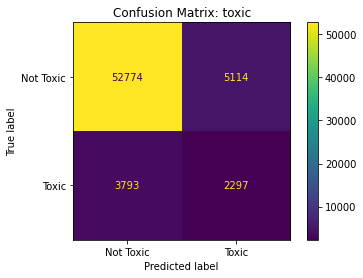

Accuracy Score for severe_toxic is : 99.41%
 
Classification Report for severe_toxic is :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.40      0.06      0.10       367

    accuracy                           0.99     63978
   macro avg       0.70      0.53      0.55     63978
weighted avg       0.99      0.99      0.99     63978

 


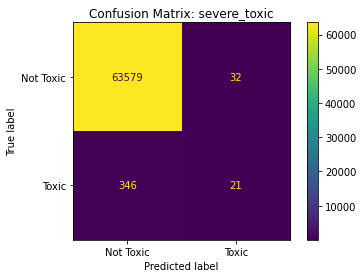

Accuracy Score for obscene is : 92.41%
 
Classification Report for obscene is :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     60287
           1       0.36      0.39      0.37      3691

    accuracy                           0.92     63978
   macro avg       0.66      0.67      0.67     63978
weighted avg       0.93      0.92      0.93     63978

 


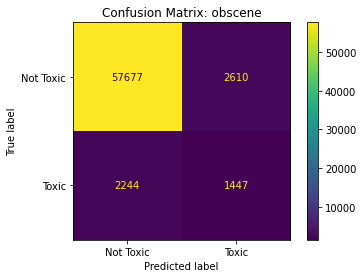

Accuracy Score for threat is : 99.67%
 
Classification Report for threat is :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       1.00      0.00      0.00       211

    accuracy                           1.00     63978
   macro avg       1.00      0.50      0.50     63978
weighted avg       1.00      1.00      1.00     63978

 


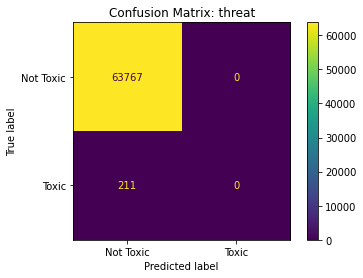

Accuracy Score for insult is : 93.50%
 
Classification Report for insult is :
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     60551
           1       0.37      0.30      0.33      3427

    accuracy                           0.94     63978
   macro avg       0.66      0.63      0.65     63978
weighted avg       0.93      0.94      0.93     63978

 


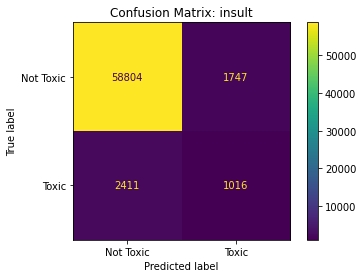

Accuracy Score for identity_hate is : 98.89%
 
Classification Report for identity_hate is :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       1.00      0.00      0.00       712

    accuracy                           0.99     63978
   macro avg       0.99      0.50      0.50     63978
weighted avg       0.99      0.99      0.98     63978

 


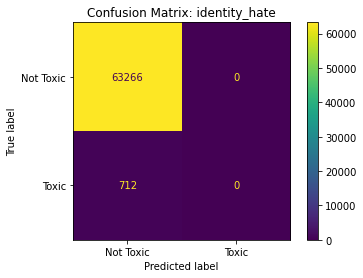

In [196]:
c = y_test.columns
for i in range(6):
  c_matrix(y_test.iloc[:, i], y_pred[:, i], 0.5, c[i])